In [6]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import paste as pst
import cv2
import anndata as ad

In [7]:
adata9 = sc.read("../data/adata.9_data_lfft_filter_25_17_30x30_002.h5ad")
adata10 = sc.read("../data/adata.10_data_lfft_filter_25_17_30x30_002.h5ad")
adata11 = sc.read("../data/adata.11_data_lfft_filter_25_17_30x30_002.h5ad")
adata12 = sc.read("../data/adata.12_data_lfft_filter_25_17_30x30_002.h5ad")

In [8]:
slices = []  
slices.append(adata9)
slices.append(adata10)
slices.append(adata11)
slices.append(adata12)

In [6]:
for j in range(4):
    slices_coor = []
    for i in range(len(slices[j].obs)):
        slice_i_coor = [slices[j].obs['x_pixel'][i], slices[j].obs['y_pixel'][i]]
        slices_coor.append(slice_i_coor)
    slices_coor = np.array(slices_coor)
    slices[j].obsm['spatial'] = slices_coor

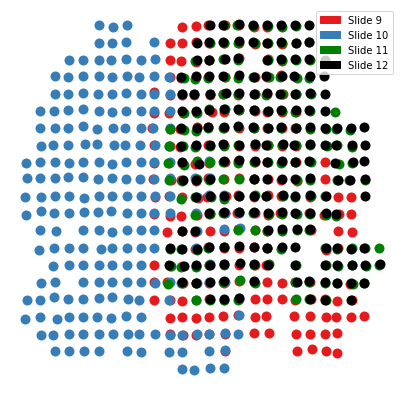

In [7]:
slice_colors = ['#e41a1c','#377eb8','green','black','yellow','grey', "#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370"]
plt.figure(figsize=(7,7))
for i in range(len(slices)):
    pst.plot_slice(slices[i],slice_colors[i],s=400)
plt.legend(handles=[mpatches.Patch(color=slice_colors[0], label='Slide 9'),mpatches.Patch(color=slice_colors[1], label='Slide 10'),mpatches.Patch(color=slice_colors[2], label='Slide 11'),mpatches.Patch(color=slice_colors[3], label='Slide 12')])
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

In [8]:
alpha = 0.1
res_df = pd.DataFrame(columns=['Sample','Pair','Kind','Time','Accuracy'])
pis = [None for i in range(3)]
for i in range(3):
    pi0 = pst.match_spots_using_spatial_heuristic(slices[i].obsm['spatial'],slices[i+1].obsm['spatial'],use_ot=True)
    pis[i] = pst.pairwise_align(slices[i], slices[i+1],alpha=alpha, G_init=pi0, norm=True, verbose=False)

new_slices = pst.stack_slices_pairwise(slices, pis)  
    
new_slices

Using selected backend cpu. If you want to use gpu, set use_gpu = True.
Using selected backend cpu. If you want to use gpu, set use_gpu = True.
Using selected backend cpu. If you want to use gpu, set use_gpu = True.


[AnnData object with n_obs × n_vars = 214 × 39739
     obs: 'nGene', 'nUMI', 'Sample', 'weeks', 'ChipBatch', 'ChipNr', 'Experiment_date', 'Experiment_procedure', 'Sequencing_date', 'Raw_reads', 'new_x', 'new_y', 'percent.mito', 'res.0.8', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'x_pixel_aligned', 'y_pixel_aligned', 'annotation', 'z_array', 'z_pixel', 'z_pixel_aligned'
     var: 'genename'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 209 × 39739
     obs: 'nGene', 'nUMI', 'Sample', 'weeks', 'ChipBatch', 'ChipNr', 'Experiment_date', 'Experiment_procedure', 'Sequencing_date', 'Raw_reads', 'new_x', 'new_y', 'percent.mito', 'res.0.8', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'x_pixel_aligned', 'y_pixel_aligned', 'annotation', 'z_array', 'z_pixel', 'z_pixel_aligned'
     var: 'genename'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 178 × 39739
     obs: 'nGene', 'nUMI', 'Sa

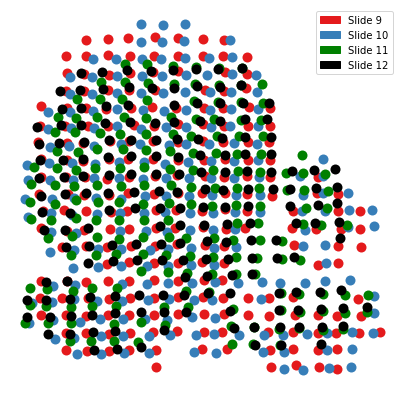

In [9]:
slice_colors = ['#e41a1c','#377eb8','green','black','yellow','grey', "#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370"]
plt.figure(figsize=(7,7))
for i in range(len(new_slices)):
    pst.plot_slice(new_slices[i],slice_colors[i],s=400)
plt.legend(handles=[mpatches.Patch(color=slice_colors[0], label='Slide 9'),mpatches.Patch(color=slice_colors[1], label='Slide 10'),mpatches.Patch(color=slice_colors[2], label='Slide 11'),mpatches.Patch(color=slice_colors[3], label='Slide 12')])
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

In [10]:
x_min = 0
y_min = 0

for j in range(4):
    for i in range(len(slices[j].obs)):
        x = new_slices[j].obsm['spatial'][i][0]
        y = new_slices[j].obsm['spatial'][i][1]
        
        if x_min > x:
            x_min = x
        if y_min > y:
            y_min = y
            
print(x_min, y_min)

-1423.4706435395126 -2257.8469551453077


In [11]:
for j in range(4):
    for i in range(len(slices[j].obs)):
        x = new_slices[j].obsm['spatial'][i][0] - x_min
        y = new_slices[j].obsm['spatial'][i][1] - y_min
        
        new_slices[j].obsm['spatial'][i][0] = x
        new_slices[j].obsm['spatial'][i][1] = y

In [12]:
for j in range(4):
    slices_coor = []
    for i in range(len(slices[j].obs)):
        slices[j].obs["x_pixel_aligned"][i] = new_slices[j].obsm['spatial'][i][0]
        slices[j].obs["y_pixel_aligned"][i] = new_slices[j].obsm['spatial'][i][1]

In [13]:
from sklearn.neighbors import NearestNeighbors

def get_coords(index):

    coords = pd.DataFrame(index=index)
    coords['x'] = index.str.split('x').str.get(0).map(float)
    coords['y'] = index.str.split('x').str.get(1).map(float)
    
    return coords

In [14]:
a = []

for j in range(4):
    df = slices[j].to_df(layer=None)
    df.index = slices[j].obs["x_pixel_aligned"].astype(str) + "x" + slices[j].obs["y_pixel_aligned"].astype(str)
    sample_info_position = get_coords(df.index)

    para_neighbors = 2
    nbrs = NearestNeighbors(n_neighbors = para_neighbors, algorithm='ball_tree').fit(sample_info_position)
    distances, indices = nbrs.kneighbors(sample_info_position)
    for i in range(len(distances)):
        a.append(distances[i][1])
np.median(a)

197.4000000000001

In [15]:
for j in range(4):
    slices_coor = []
    for i in range(len(slices[j].obs)):
        new_slices[j].obs["x_pixel_aligned"][i] = new_slices[j].obsm['spatial'][i][0] / 197.4 * 200.0
        new_slices[j].obs["y_pixel_aligned"][i] = new_slices[j].obsm['spatial'][i][1] / 197.4 * 200.0


In [16]:
adata9, adata10, adata11, adata12 = new_slices

In [17]:
counts_9 = adata9.to_df(layer=None)
counts_10 = adata10.to_df(layer=None)
counts_11 = adata11.to_df(layer=None)
counts_12 = adata12.to_df(layer=None)

obs_9 = adata9.obs
obs_10 = adata10.obs
obs_11 = adata11.obs
obs_12 = adata12.obs

df = pd.concat([counts_9, counts_10, counts_11, counts_12])
obs = pd.concat([obs_9, obs_10, obs_11, obs_12])
obs['z_pixel_aligned'] = obs['z_pixel']

adata_week6_new = ad.AnnData(df)
adata_week6_new.obs = obs

adata_week6_new.obs

adata_week6_new.write_h5ad("../data/adata3D_week6_four_spe.h5ad")

... storing 'Sample' as categorical
